## Imports

In [1]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
import shutil
import os, sys

# eKDS Stuff
from src.Graph import Background, Circle, Disk
from src.eKDS import Graph, eKDS, emd
from src.plot_utils import load_data, plot, plot_event, make_gif, timer_func

ModuleNotFoundError: No module named 'Graph'

## Datasets

This part of the code can be modified, as long as the final datasets have the same format! Doesn't have to be physics-themed

In [ ]:
# Parameters
R = 0.5
N = 50
epochs = 150
plot_dir = "results"

# events should be of the form ((positions), (weights))
def load_dataset(filename):

        X = np.load(filename, "r",)[:N]
        X = np.copy(X)
        print(X.shape)
    
        # Normalize & Center
        events = []
        for x in X:
            
            zs = x[:,0] / np.sum(x[:,0])
            
            mask = zs[:] > 0
            yphi_avg = np.average(x[mask,1:3], weights = x[mask,0], axis = 0)
            x[mask,1:3] -= yphi_avg  
            events.append( (x[:,1:3] , zs ) )

        return events

signal = load_dataset("../Datasets/top/v0/signal_train.npy")
background = load_dataset("../Datasets/top/v0/background_train.npy")
events = [signal, background]
event_labels = ["signal", "background"]
colors = ["red", "blue"]

(200, 200, 3)
(200, 200, 3)


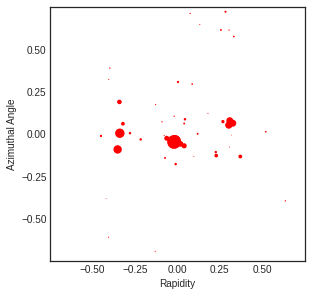

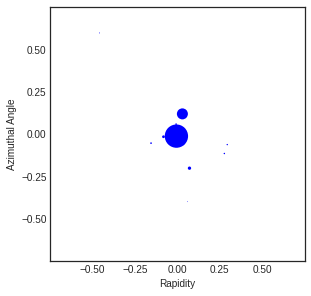

In [ ]:
# Example plots
example_signal = signal[0]
plot_event(example_signal[0], example_signal[1], R, color = "red")

example_background = background[0]
plot_event(example_background[0], example_background[1], R, color = "blue")

## Observables

In [ ]:
# Define a generic observable. This is a function that takes an event and a shape, trains the NN, and returns the EMD+shape parameters:
@timer_func
def generic_obseravble(event, shapes, R, plot_dir = None, name = None, color = None,**kwargs):
    
    
    y_i, z_i = event

    # Obersvable (l, parameters) = result of training a network
    net = eKDS(shapes, R)
    l, x_ij  = net.train(y_i, z_i, epochs, lr = 0.05, **kwargs)
    
    # Optionally plot the event and learned polygon
    if plot_dir is not None:
        y_j, z_j = net.get_samples()
        plot(y_i, z_i, y_j, z_j, x_ij, l, R, 0.0, plot_dir + "_%s.png" % name, name, shapes, color, )

    return l, shapes

Can change these observables to any shapes you want!

In [ ]:
# One-diskness
def one_diskness(event, plot_dir = None, color = None, **kwargs):
            return generic_obseravble(event,
            shapes = [Background((-R, -R), (R, R), z = 0, N = 150), Disk( (0,0), 0.5, N = 150) ],
            R = R,
            plot_dir = plot_dir,
            name = "1-Diskness+Pileup",
            color = color,
            **kwargs
            )

# Two-diskness
def two_diskness(event, plot_dir = None, color = None, **kwargs):
            return generic_obseravble(event,
            shapes = [Background((-R, -R), (R, R), z = 0, N = 150),
                      Disk( (0,-0.1), 0.5, N = 75),
                      Disk( (0, 0.1), 0.5, N = 75)],
            R = R,
            plot_dir = plot_dir,
            name = "2-Diskness+Pileup",
            color = color,
            **kwargs
            )

# Three-diskness
def three_diskness(event, plot_dir = None, color = None, **kwargs):
            return generic_obseravble(event,
            shapes = [Background((-R, -R), (R, R), z = 0, N = 150),
                      Disk( (0,-0.1), 0.5, N = 50),
                      Disk( (0, 0.0), 0.5, N = 50),
                      Disk( (0, 0.1), 0.5, N = 50)],
            R = R,
            plot_dir = plot_dir,
            name = "3-Diskness+Pileup",
            color = color,
            **kwargs
            )

observables = [one_diskness, two_diskness, three_diskness]
observable_labels = ["1-Diskness+Pileup", "2-Diskness+Pileup", "3-Diskness+Pileup"]


## Run 

In [ ]:
emds = np.zeros(shape = (len(events),len(observables), N))

# Calculate the EMDs for each observable, for each event
for (i, event_type) in enumerate(events):
    for (j, obs) in enumerate(observables):
        for (k, event) in enumerate(events[i]):

            l, shapes = obs(event, 
                            plot_dir = plot_dir + "/%s/event_%d" % (event_labels[i], k), 
                            color = colors[i],
                            flavor_text = "%s Event %s %d" % (observable_labels[j], event_labels[i], k)
                            )
            emds[i,j,k] = l

2022-01-31 23:01:18.767210: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-31 23:01:22.834275: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-31 23:01:22.834318: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rikab-LENOVO-Y700-15ISK): /proc/driver/nvidia/version does not exist
2022-01-31 23:01:22.835084: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-01-31 23:01:23.499226: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2022-01-31 23:01:23.533650: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555e733418b0 initialized for platform Host (this does not guarantee that XLA will b

1-Diskness+Pileup Event signal 0: Epoch 0: 0.480, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 1: 0.454, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 2: 0.400, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 3: 0.386, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 4: 0.382, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 5: 0.371, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 6: 0.363, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 7: 0.366, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 8: 0.367, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 9: 0.373, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 10: 0.376, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 11: 0.375, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 12: 0.374, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 13: 0.376, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 14: 0.372, z0 = 0.000
1-Diskness+Pileup Event signal 0: Epoch 15: 0.368, z0 = 0.000
1-Diskness+Pileup 

## Plots

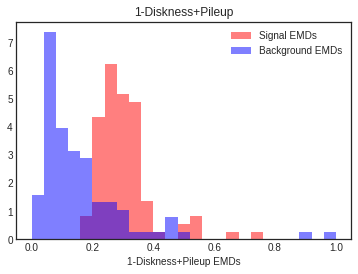

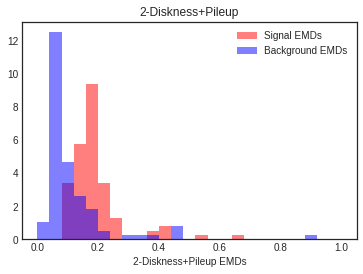

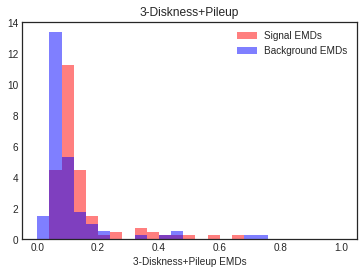

In [ ]:
np.save("emds.npy", emds, )

for (j, obs) in enumerate(observables):
    plt.hist(emds[0,j,:], bins = 25, range=(0.0, 1.0), density = True, color = "red", label = "Signal EMDs", histtype="stepfilled", alpha = 0.5)
    plt.hist(emds[1,j,:], bins = 25, range=(0.0, 1.0), density = True, color = "blue", label = "Background EMDs", histtype="stepfilled", alpha = 0.5)
    plt.title(observable_labels[j])
    plt.xlabel(r"%s EMDs" % observable_labels[j])
    plt.legend()
    plt.show()
    

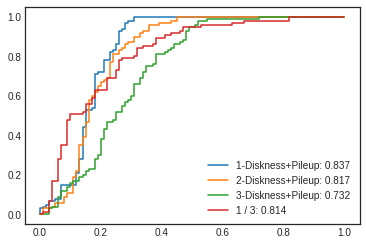

In [ ]:
# AUC 
from sklearn import metrics

y = np.array([1]*N + [0]*N)
for j in range(len(observables)):
    pred = np.concatenate( (emds[0,j,:], emds[1,j,:]))
    fpr, tpr, thresholds = metrics.roc_curve(y, pred)
    plt.plot(fpr, tpr, label = "%s: %.3f" %(observable_labels[j],metrics.auc(fpr, tpr) ))


def sigmoid(z):
    return 1/(1+np.exp(-z))

pred = sigmoid(np.concatenate( (emds[0,0,:], emds[1,0,:])) / np.concatenate( (emds[0,2,:], emds[1,2,:])))
fpr, tpr, thresholds = metrics.roc_curve(y, pred)

plt.plot(fpr, tpr, label = "%s: %.3f" %("1 / 3",metrics.auc(fpr, tpr) ))
plt.legend()

(100, 3)
(100, 3)


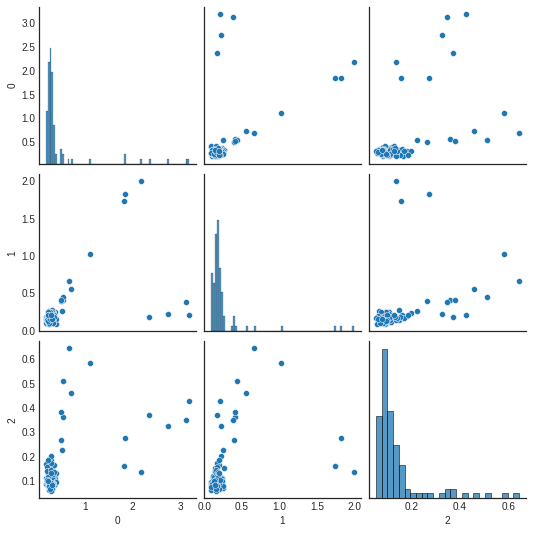

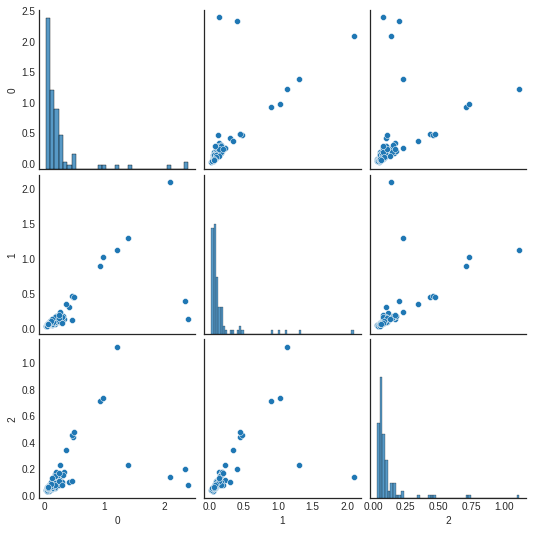

In [ ]:
# Fancy plots
import seaborn as sns
import pandas as pd

df = pd.DataFrame(np.transpose(emds[0]), )
print(df.shape)
sns.pairplot(df)

df = pd.DataFrame(np.transpose(emds[1]), )
print(df.shape)
sns.pairplot(df)
